In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_net(size):
    A = np.zeros((size, size))
    for col in A:
        num_links = np.random.randint(0, size)
        for i in range(num_links):
            col[i] = 1 / num_links
        np.random.shuffle(col)
    A = A.transpose()
    return A

def calculateM(A, alpha):
    M = (1 - alpha) * A
    S = np.ones((M.shape[0], M.shape[0]))
    S = (alpha / M.shape[0]) * S
    M = M + S
    return M

In [3]:
def get_constants(A, gamma):
    beta = 4 + A.shape[0] * gamma
    mu = 1.99 / beta
    return beta, mu

In [4]:

A = create_net(1000)
M = calculateM(A, 0.15) #alpha = 0.15
net = pd.DataFrame(A)
net.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.001848,0.000000,0.0,0.000000,0.001007,0.000000,0.000000,0.000000,0.002959,0.000000,...,0.0,0.000000,0.001812,0.001101,0.001621,0.0,0.000000,0.001996,0.000000,0.0
1,0.000000,0.002488,0.0,0.000000,0.001007,0.000000,0.000000,0.001155,0.000000,0.002041,...,0.0,0.000000,0.001812,0.001101,0.001621,0.0,0.001466,0.001996,0.000000,0.0
2,0.000000,0.000000,0.0,0.010753,0.001007,0.002024,0.001818,0.001155,0.000000,0.002041,...,0.0,0.000000,0.000000,0.001101,0.001621,0.0,0.001466,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.001007,0.002024,0.000000,0.000000,0.000000,0.000000,...,0.0,0.005587,0.001812,0.001101,0.000000,0.0,0.001466,0.001996,0.004444,0.0
4,0.000000,0.000000,0.0,0.010753,0.001007,0.002024,0.000000,0.001155,0.002959,0.000000,...,0.0,0.005587,0.000000,0.001101,0.001621,0.0,0.001466,0.001996,0.000000,0.0


In [5]:
def get_gamma(n_sqrd, size):
    if(n_sqrd):
        return float (1) / size * size #gamma = 1 / n²
    return float (1) / size            #gamma = 1 / n

gamma = get_gamma(False, M.shape[0])
beta, mu = get_constants(A, gamma)

In [6]:
def get_score_vector(M):
    v, w = np.linalg.eig(M)
    v = np.real(v)
    (m,) = np.shape(v)
    for i in range(m):
        if abs(v[i]-1) < 1e-2:
            vi = w[:, i]
    vi = np.real(vi)
    vi = vi/np.linalg.norm(vi, 1)
    vi = np.round(vi, 3)
    return(vi)

def get_random_x(size):
    return np.matrix(np.random.randint(size-1, size=size).reshape((size, 1)))

In [7]:
def DF(x, M, gamma):
    I = np.identity(M.shape[0])
    e = np.ones((M.shape[0], 1))

    mul = np.transpose(M - I) * (M - I)
    scalar = np.sum(x) - 1
    DF = mul * x + gamma * e * scalar
    return DF

def F(x, M, gamma):
    ''' inner_x = 1/2 ||Mx - x||
        inner_y = gamma/2 (sum(x) -1)^2'''
    inner_X = 0.5 * np.linalg.norm( M * x - x )
    inner_Y = gamma * 0.5 * (np.sum(x) - 1) ** 2
    return np.round(inner_X + inner_Y, 5)

In [8]:
x_etoile = get_score_vector(M)
x_current = get_random_x(M.shape[0])
DF_x_etoile = DF(x_etoile, M, gamma)

In [9]:
points = []
logs = []
fs = []
iterations = 20

In [10]:
for i in range(iterations):
    DF_x_current = DF(x_current, M, gamma)
    x_current = x_current - mu * DF_x_current
    points.append(np.linalg.norm(x_current - x_etoile))
    logs.append(np.log(1 + np.linalg.norm(x_etoile - x_current)))
    fs.append(F(x_current, M, gamma))

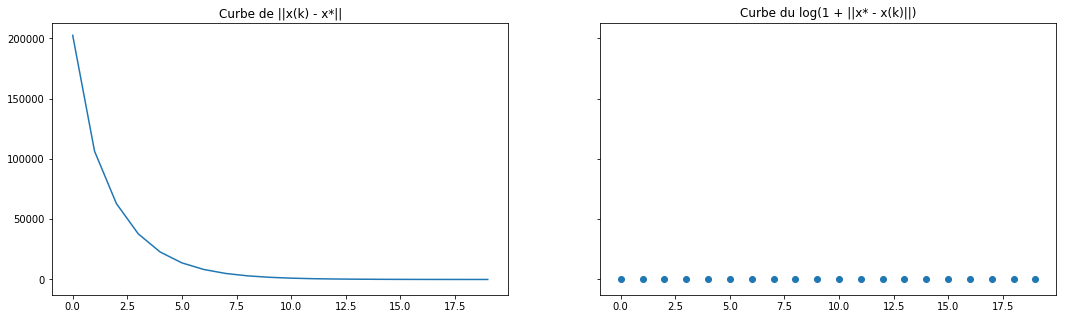

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 5))
x = [x for x in range(0, iterations)]
ax1.plot(x, points)
ax1.set_title('Curbe de ||x(k) - x*||')
ax2.scatter(x, logs)
ax2.set_title('Curbe du log(1 + ||x* - x(k)||)')
plt.show()

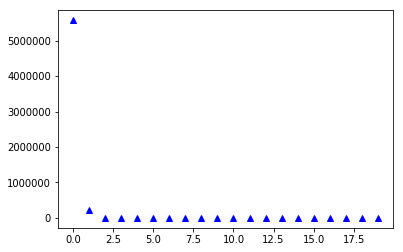

In [12]:
plt.plot([x for x in range(0, iterations)], fs, 'b^')
plt.show()